In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import torch.nn.functional as F
import torchvision
from torchvision.utils import make_grid
from PIL import Image,ImageOps
from torch.optim.lr_scheduler import CosineAnnealingLR



In [2]:
class SigDataset_train(Dataset):
    """
    A PyTorch Dataset class for handling signature images, including both original and forged signatures.
    """

    def __init__(self, orig_path, forg_path, transforms=None):
        """
        Initializes the dataset with paths to the original and forged signatures.

        Parameters:
        - orig_path (str): Path to the directory containing original signatures.
        - forg_path (str): Path to the directory containing forged signatures.
        - transforms (callable, optional): Optional transform to be applied on a sample.
        """
        self.orig_path = orig_path
        self.forg_path = forg_path
        self.transform = transforms
        self.original_sig = os.listdir(self.orig_path)  # List of original signature files

    def __getitem__(self, idx):
        """
        Returns a pair of images (original and either original or forged) and a label indicating 
        whether the second image is forged or not.

        Parameters:
        - idx (int): Index of the data item.

        Returns:
        - img0 (Tensor): The original image.
        - img1 (Tensor): The second image (original or forged).
        - label (Tensor): A tensor with a single element, 0 for original and 1 for forged.
        """
        # Determine the person ID and sample number
        person_id = int(idx % 44) + 1  # Total of 44 authors
        sample = str(int(np.random.randint(low=1, high=25, size=1)))  # Randomly pick a signature

        # Construct the original image file name and path
        org_img_name = f'original_{person_id}_{sample}.png'
        org_img_path = os.path.join(self.orig_path, org_img_name)
        org_img = Image.open(org_img_path).convert('L')
        img0 = ImageOps.invert(org_img)

        # Randomly choose whether the second image is original (0) or forged (1)
        label = int(np.random.randint(low=0, high=2, size=1))

        if label == 1:
            # Pick a forged image
            sample1 = str(int(np.random.randint(low=1, high=25, size=1)))
            forg_img_name = f'forgeries_{person_id}_{sample1}.png'
            forg_img_path = os.path.join(self.forg_path, forg_img_name)
            forg_img = Image.open(forg_img_path).convert('L')
            img1 = ImageOps.invert(forg_img)
        else:
            # Pick another original image
            sample2 = str(int(np.random.randint(low=1, high=25, size=1)))
            sim_img_name = f'original_{person_id}_{sample2}.png'
            sim_img_path = os.path.join(self.orig_path, sim_img_name)
            sim_img = Image.open(sim_img_path).convert('L')
            img1 = ImageOps.invert(sim_img)
            
        # Apply transformations if provided
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        # Return the images and the label
        return img0, img1, torch.from_numpy(np.array([int(label)], dtype=np.float32))

    def __len__(self):
        """
        Returns the total number of samples in the dataset.

        Returns:
        - (int): Total number of samples.
        """
        return 44 * 24  # Total number of authors times the number of samples per author

In [3]:
class SigDataset_test(Dataset):
    """
    A PyTorch Dataset class for handling test signature images, including both original and forged signatures.
    """

    def __init__(self, orig_path, forg_path, transforms=None):
        """
        Initializes the dataset with paths to the original and forged signatures for testing.

        Parameters:
        - orig_path (str): Path to the directory containing original signatures.
        - forg_path (str): Path to the directory containing forged signatures.
        - transforms (callable, optional): Optional transform to be applied on a sample.
        """
        self.orig_path = orig_path
        self.forg_path = forg_path
        self.transform = transforms
        self.original_sig = os.listdir(self.orig_path)  # List of original signature files

    def __getitem__(self, idx):
        """
        Returns a pair of images (original and either original or forged) and a label indicating 
        whether the second image is forged or not.

        Parameters:
        - idx (int): Index of the data item.

        Returns:
        - img0 (Tensor): The original image.
        - img1 (Tensor): The second image (original or forged).
        - label (Tensor): A tensor with a single element, 0 for original and 1 for forged.
        """
        # Determine the person ID and sample number for testing
        person_id = int(idx % 11) + 45  # Total of 11 authors for testing, starting from 45
        sample = str(int(np.random.randint(low=1, high=25, size=1)))  # Randomly pick a signature

        # Construct the original image file name and path
        org_img_name = f'original_{person_id}_{sample}.png'
        org_img_path = os.path.join(self.orig_path, org_img_name)
        org_img = Image.open(org_img_path).convert('L')
        img0 = ImageOps.invert(org_img)

        # Randomly choose whether the second image is original (1) or forged (0)
        label = int(np.random.randint(low=0, high=2, size=1))

        if label == 0:
            # Pick a forged image
            sample1 = str(int(np.random.randint(low=1, high=25, size=1)))
            forg_img_name = f'forgeries_{person_id}_{sample1}.png'
            forg_img_path = os.path.join(self.forg_path, forg_img_name)
            forg_img = Image.open(forg_img_path).convert('L')
            img1 = ImageOps.invert(forg_img)
        else:
            # Pick another original image
            sample2 = str(int(np.random.randint(low=1, high=25, size=1)))
            sim_img_name = f'original_{person_id}_{sample2}.png'
            sim_img_path = os.path.join(self.orig_path, sim_img_name)
            sim_img = Image.open(sim_img_path).convert('L')
            img1 = ImageOps.invert(sim_img)
            
        # Apply transformations if provided
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        # Return the images and the label
        return img0, img1, torch.from_numpy(np.array([int(label)], dtype=np.float32))

    def __len__(self):
        """
        Returns the total number of samples in the test dataset.

        Returns:
        - (int): Total number of samples.
        """
        return 11 * 24  # Total number of authors for testing times the number of samples per author


In [4]:
#load the dataset from raw image folders
train_dataset=SigDataset_train(r"/kaggle/input/cedardataset/signatures/full_org",r"/kaggle/input/cedardataset/signatures/full_forg",
                               transforms=transforms.Compose([transforms.Resize((300,300)),transforms.ToTensor()]))

In [5]:
# ## Visualizing one image ##

# random_idx = int(np.random.randint(low = 0 , high = len(siamese_dataset) , size = 1))

# orig_img , comp_img , label = siamese_dataset[random_idx]

# print('Label :' , label)

# print('Original Image')
# print('Shape :' , orig_img.shape)
# plt.imshow(orig_img.permute(1 , 2 , 0))
# plt.show()

# print('Comparative Image')
# print('Shape :' , comp_img.shape)
# plt.imshow(comp_img.permute(1 , 2 , 0))
# plt.show()

In [6]:
# ## Visualization ##
# train_dataloader=DataLoader(siamese_dataset,shuffle=True,batch_size=64,drop_last=True)

# for org_img , comp_img , label in train_dataloader:

#     # Visualizing original images #

#     fig , ax = plt.subplots(figsize = (8 , 8))
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])

#     plt.imshow(make_grid(org_img , 8).permute(1 , 2 , 0))
#     plt.show()

#     # Visualizing Comparative images #

#     fig , ax = plt.subplots(figsize = (8 , 8))
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])

#     plt.imshow(make_grid(comp_img , 8).permute(1 , 2 , 0))
#     plt.show()

#     break

In [7]:
class AutoEncoder(nn.Module):
    """
    A convolutional autoencoder model for image compression and reconstruction.
    Includes an encoder and decoder with an additional feature extractor network.
    """

    def __init__(self):
        """
        Initializes the AutoEncoder with defined encoder, decoder, and feature extractor networks.
        """
        super(AutoEncoder, self).__init__()

        # Encoder: Convolutional layers with pooling for downsampling the input image
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=9, stride=1, padding=4),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=5, stride=1, padding=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.flatten = nn.Flatten()

        # Decoder: Transpose convolutional layers for upsampling and reconstructing the input image
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
            nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
            nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2),
            nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1),
            nn.Upsample(scale_factor=1.045, mode='bicubic')  # Upsample to match original size
        )

        # Feature extraction network for generating encoded representations
        self.Sim1 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(1296, 324),
            nn.Linear(324, 256),
            nn.Linear(256, 128),
            nn.Linear(128, 64),
        )

    def forward(self, x, y):
        """
        Forward pass for the AutoEncoder model.

        Parameters:
        - x (Tensor): First input image batch.
        - y (Tensor): Second input image batch.

        Returns:
        - x (Tensor): Reconstructed first image batch.
        - y (Tensor): Reconstructed second image batch.
        - encoding_x (Tensor): Encoded representation of the first image batch.
        - encoding_y (Tensor): Encoded representation of the second image batch.
        """
        x = self.encoder(x)
        encoding_x = self.Sim1(self.flatten(x))
        x = self.decoder(x)

        y = self.encoder(y)
        encoding_y = self.Sim1(self.flatten(y))
        y = self.decoder(y)

        return x, y, encoding_x, encoding_y


class SimNet(nn.Module):
    """
    A similarity network for comparing encoded image representations.
    """

    def __init__(self):
        """
        Initializes the SimNet with a fully connected network to compute similarity.
        """
        super(SimNet, self).__init__()

        # Fully connected network to compute similarity between image encodings
        self.Simaese = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(64, 32),
            nn.Linear(32, 16),
            nn.Dropout(p=0.3),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x_encoding, y_encoding):
        """
        Forward pass for the SimNet model.

        Parameters:
        - x_encoding (Tensor): Encoded representation of the first image batch.
        - y_encoding (Tensor): Encoded representation of the second image batch.

        Returns:
        - out (Tensor): Similarity score between the encoded representations.
        """
        diff = x_encoding - y_encoding
        out = self.Simaese(diff)

        return out


In [8]:
# # Example usage
# model = AutoEncoder()
# model2=SimNet()

# dummy_input_x = torch.randn(1, 1, 300, 300)  # Example input shape (batch_size, channels, height, width)
# dummy_input_y = torch.randn(1, 1, 300, 300)  # Example input shape (batch_size, channels, height, width)
# output = model(dummy_input_x,dummy_input_y)
# out=model2(output[2],output[3])
# print(output[0].shape,output[1].shape,output[2].shape,output[3].shape)

# # print("Output shape:", output.shape)  # Check the final output shape


In [9]:
# print(out)

In [10]:


class RanaKaGhata(nn.Module):
    """
    Custom loss function combining L1 loss for reconstruction and binary cross-entropy for similarity prediction.
    """

    def __init__(self, beta=1.0):
        """
        Initializes the RanaKaGhata loss module.

        Parameters:
        - beta (float): Weighting factor for balancing reconstruction and similarity loss components.
        """
        super(RanaKaGhata, self).__init__()
        self.beta = beta

    def forward(self, x_orig, y_orig, x_predict, y_predict, sim, label):
        """
        Computes the combined loss for autoencoder reconstruction and similarity prediction.

        Parameters:
        - x_orig (Tensor): Original first input images.
        - y_orig (Tensor): Original second input images.
        - x_predict (Tensor): Reconstructed first input images.
        - y_predict (Tensor): Reconstructed second input images.
        - sim (Tensor): Similarity prediction scores.
        - label (Tensor): True labels for similarity (0 for dissimilar, 1 for similar).

        Returns:
        - loss (Tensor): Calculated loss value.
        """
        reconstruction_loss = F.l1_loss(x_orig, x_predict) + F.l1_loss(y_orig, y_predict)
        similarity_loss = F.binary_cross_entropy(sim, label)
        loss = self.beta * reconstruction_loss + similarity_loss
        
        return loss


In [11]:
def check_accuracy(model_1, model_2, dataloader, batch_size, datasplit=None):
    """
    Computes the accuracy of two models on a given dataset.

    Parameters:
    - model_1 (nn.Module): The first model, typically an autoencoder.
    - model_2 (nn.Module): The second model, typically a similarity network.
    - dataloader (DataLoader): PyTorch DataLoader containing the dataset to evaluate.
    - batch_size (int): The number of samples per batch to load.
    - datasplit (str, optional): A string to denote the data split being evaluated (e.g., 'train', 'test').

    Returns:
    - None: Prints the accuracy of the models on the dataset.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    net_1 = model_1.to(device)
    net_2 = model_2.to(device)

    # Set both models to evaluation mode
    net_1.eval()
    net_2.eval()

    correct = 0
    incorrect = 0

    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            x, y, label = data
            x, y, label = x.to(device), y.to(device), label.to(device)

            # Forward pass through the first model to obtain encoded representations
            output_x, output_y, encoding_x, encoding_y = net_1(x, y)
            
            # Forward pass through the second model to obtain similarity prediction
            prob_forged = net_2(encoding_x, encoding_y)
            predicted_label = prob_forged > 0.5

            # Calculate the number of correct predictions
            correct_prediction = torch.sum(predicted_label == label)
            correct += correct_prediction.item()
            incorrect += (batch_size - correct_prediction.item())

    # Calculate and print the accuracy
    accuracy = correct / (correct + incorrect)
    if datasplit is not None:
        print(f"The accuracy on {datasplit} data is {accuracy:.4f}")
    else:
        print(f"The accuracy is {accuracy:.4f}")


/tmp/ipykernel_34/1387468097.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sample = str(int(np.random.randint(low = 1 , high = 25 , size = 1)))# for Randomly picking a signature
/tmp/ipykernel_34/1387468097.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(np.random.randint(low = 0 , high = 2 , size = 1)) # selecting the second image.
/tmp/ipykernel_34/1387468097.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sample2 = str(int(np.random.

1.0139987468719482
0.8513274192810059
0.5991371870040894
0.4298962950706482
Epoch 0
 Current loss 0.7235899120569229

the accuracy on test data is 0.7421875 
0.4268267750740051
0.5749993324279785
0.44092196226119995
0.3999432325363159
Epoch 1
 Current loss 0.4606728255748749

the accuracy on test data is 0.80859375 
0.5273366570472717
0.6198977828025818
0.4426842927932739
0.49787378311157227
Epoch 2
 Current loss 0.5219481289386749

the accuracy on test data is 0.79296875 
0.37907299399375916
0.4769304096698761
0.5328910946846008
0.4326687455177307
Epoch 3
 Current loss 0.4553908109664917

the accuracy on test data is 0.7578125 
0.4369518756866455
0.49011147022247314
0.4540868401527405
0.49290210008621216
Epoch 4
 Current loss 0.4685130715370178

the accuracy on test data is 0.7890625 
0.43518710136413574
0.46010714769363403
0.4003790616989136
0.48751339316368103
Epoch 5
 Current loss 0.4457966759800911

the accuracy on test data is 0.82421875 
0.4707523584365845
0.403159499168396
0.48

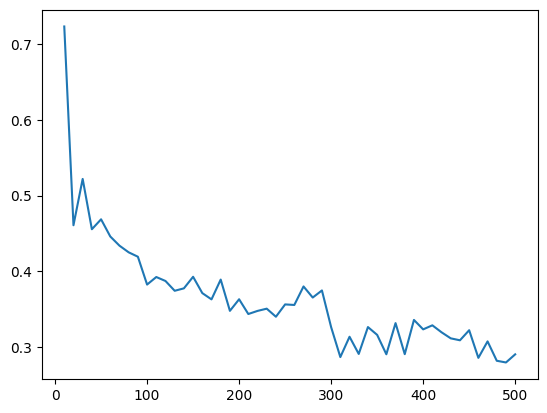

Models Saved Successfully


In [12]:
# Define your dataset classes and models here (e.g., SigDataset_test, AutoEncoder, SimNet, RanaKaGhata)

# Define transforms
transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor()
])

# Load training and test data
train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=64,
    drop_last=True
)

test_dataset = SigDataset_test(
    r"/kaggle/input/cedardataset/signatures/full_org",
    r"/kaggle/input/cedardataset/signatures/full_forg",
    transforms=transform
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=True,
    drop_last=True
)

# Declare Siamese Network
net_1 = AutoEncoder().cuda()
net_2 = SimNet().cuda()
net_1.train()
net_2.train()

# Declare Loss Function
criterion = RanaKaGhata()

# Declare Optimizer
optimizer_1 = optim.Adam(net_1.parameters(), lr=1e-3)
optimizer_2 = optim.Adam(net_2.parameters(), lr=1e-4)
scheduler_1 = CosineAnnealingLR(optimizer_1, T_max=15)
scheduler_2 = CosineAnnealingLR(optimizer_2, T_max=15)

# Train the model
def train(epochs=50):
    """
    Train the Siamese Network models.

    Parameters:
    - epochs (int): The number of training epochs.

    Returns:
    - net_1 (AutoEncoder): The trained AutoEncoder model.
    - net_2 (SimNet): The trained SimNet model.
    """
    loss = []
    counter = []
    iteration_number = 0
    
    for epoch in range(epochs):
        loss_temp = []
        
        for i, data in enumerate(train_dataloader, 0):
            img0, img1, label = data
            img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()
            
            optimizer_1.zero_grad()
            optimizer_2.zero_grad()
            
            output_x, output_y, encoding_x, encoding_y = net_1(img0, img1)
            sim = net_2(encoding_x, encoding_y)
            
            loss_test = criterion(img0, img1, output_x, output_y, sim, label)
            
            if (i % 4) == 0:
                print(loss_test.item())
                loss_temp.append(loss_test.item())
            
            loss_test.backward()
            optimizer_1.step()
            optimizer_2.step()
            scheduler_1.step()
            scheduler_2.step()
        
        epoch_loss = np.mean(loss_temp)
        print(f"Epoch {epoch}\n Current loss {epoch_loss}\n")
        
        iteration_number += 10
        counter.append(iteration_number)
        loss.append(epoch_loss)
        
        if epoch % 1 == 0:
            check_accuracy(net_1, net_2, test_dataloader, batch_size=32, datasplit='test')
    
    plt.plot(counter, loss)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()
    
    return net_1, net_2

# Set the device to CUDA if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Train the models
model_1, model_2 = train()

# Save the trained model states
torch.save(model_1.state_dict(), "auto_siamese-model_1_state_dicts.pt")
torch.save(model_2.state_dict(), "auto_siamese-model_2_state_dicts.pt")
print("Models Saved Successfully")


In [14]:
# check accuracy on training dataset
check_accuracy(model_1,model_2,train_dataloader,batch_size=64,datasplit='train')

/tmp/ipykernel_34/1387468097.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sample = str(int(np.random.randint(low = 1 , high = 25 , size = 1)))# for Randomly picking a signature
/tmp/ipykernel_34/1387468097.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(np.random.randint(low = 0 , high = 2 , size = 1)) # selecting the second image.
/tmp/ipykernel_34/1387468097.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sample1 = str(int(np.random.

the accuracy on train data is 0.99609375 
